In [1]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd
import pprint

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# To suppress warnings
import warnings
default_color_palette       = ["#f44336", "#e81e63", "#9c27b0", "#673ab7", "#3f51b5", "#2196f3", "#03a9f4", "#00bcd4","#009688","#4caf50","#8bc34a","#cddc39","#ffeb3b","#ffc107","#ff9800", "#ff5722","#795548","#9e9e9e","#607d8b","#03A9F4","#7C4DFF", "#FF5252", "#D50000", "#FF6F00", "#0288D1", "#7C4DFF"]
maritalstatus_color_palette = {'single':'#ff3d00', 'married':'#00c853', 'divorced': '#EA112F'}
stats_colors                = {'Mean':'#D50000', 'Mode':'#FF3D00', 'Median':'#2962FF'}

In [2]:
data = pd.Series([1, 1, 6, 13, 13, 14, 14, 15, 15, 16, 18, 18, 18, 19, 100, 300], name="feature_1")
data2 = pd.Series([8, 60, 6, 13, 13, 14, 14, 15, 15, 16, 18, 18, 18, 19, 100, 300], name="feature_2")
# target = pd.Series([1, 2, 5, 15, 13, 18, 14, 15, 14, 16, 18, 18, 18, 25, 30, 14], name="target")
target = pd.Series(["yes", "no", "yes", "no", "yes", "no", "yes", "no", "yes", "no", "yes", "no", "yes", "no", "yes", "no"], name="Target")
main_data = pd.concat([data, data2, target], axis=1).reset_index()
main_data.drop("index", axis=1, inplace=True)

main_data

,feature_1,feature_2,Target
0,1,8,yes
1,1,60,no
2,6,6,yes
3,13,13,no
4,13,13,yes
5,14,14,no
6,14,14,yes
7,15,15,no
8,15,15,yes
9,16,16,no


In [3]:
replace_struct = {
    #"month"      : {"jan": 1, "feb": 2, "apr": 3, "mar": 4, "may": 5, "jun":6, "jul":7, "aug":8, "sep":9, "oct": 10, "nov": 11, "dec": 12},
    #"contact"   : {"unknown": -1, "telephone": 1, "cellular": 2},
    #"education" : {"primary": 1, "secondary": 2, "tertiary": 3},
    "Target"    : {"no": 0, "yes": 1},
}

main_data = main_data.replace(replace_struct)
main_data.head(10)

,feature_1,feature_2,Target
0,1,8,1
1,1,60,0
2,6,6,1
3,13,13,0
4,13,13,1
5,14,14,0
6,14,14,1
7,15,15,0
8,15,15,1
9,16,16,0


In [4]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   feature_1  16 non-null     int64
 1   feature_2  16 non-null     int64
 2   Target     16 non-null     int64
dtypes: int64(3)
memory usage: 512.0 bytes


In [5]:
'''
Input:
Axis, column name/x-axis, hue name

Output:
Displays a count plot.

Retunrs:
N/A
''' 
def HistBoxplot(box_chart_ax, hist_chart_ax, x_axis, df):
    sns.boxplot(
        data=df,
        x=df[x_axis],
        showmeans=True,
        ax=box_chart_ax)
    
    sns.histplot(
        data=df,
        x=df[x_axis],
        kde=True,
        ax=hist_chart_ax)
    
    hist_chart_ax.axvline(df[x_axis].mean(),                 # Get the mean of the values in the given column and draw a vertical line that cuts the chart on the mean value 
               color=stats_colors['Mean'],                                  # Use on of the colors predefined on this notebook
               label='Mean',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(df[x_axis].median(),               # Plot the median line on the chart.
               color=stats_colors['Median'],                                # Use on of the colors predefined on this notebook
               label='Median',                                              # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(df[x_axis].mode()[0],              # Plot the mode line on the chart.
               color=stats_colors['Mode'],                                  # Use on of the colors predefined on this notebook 
               label='Mode',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.legend(loc='upper right')

'''
Input:
N/A

Output:
Displays a a grid of [Boxplot x Distribution chart] for discrete features.

Returns:
N/A
''' 
def PlotHistBoxGrid(df):
    col_names = df.select_dtypes(include=['float', 'int64', 'uint8']).columns.tolist()
    print(col_names)

    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, (box, hist) = plt.subplots(
            nrows=2,                                                                # Number of rows of the grid
            ncols=3,                                                                # Number of columns of the grid.
            figsize=(15,4),
            gridspec_kw={"height_ratios" : (0.25,0.5)},
            constrained_layout=True)

        for index in range(0, 3):
            if col_index < int(len(col_names)):
                HistBoxplot(box.flat[index], hist.flat[index], col_names[col_index], df)
            col_index += 1

['feature_1', 'feature_2', 'Target']


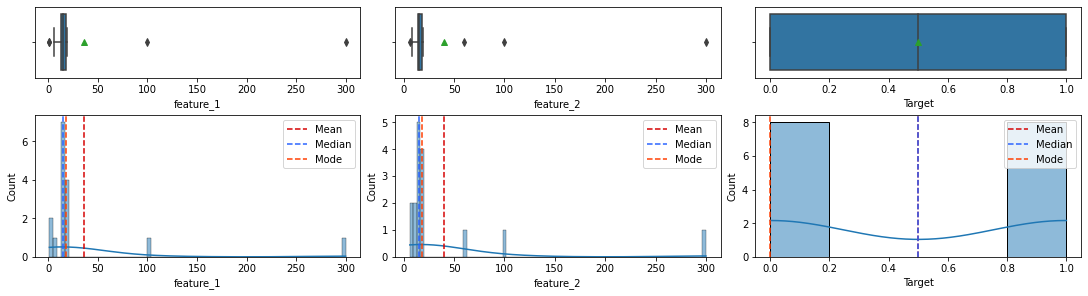

In [6]:
PlotHistBoxGrid(main_data)

In [9]:
def Get_IQR(data):
    quartiles = np.quantile(data, [.25, .75])
    iqr = (quartiles[1] - quartiles[0])
    return {
        "Q1": quartiles[0],
        "Q3": quartiles[1],
        "IQR": iqr
    }

def RemoveOutliers(df):
    main_data_copy = df.copy()
    col_names = main_data_copy.select_dtypes(include=['float', 'int64']).columns.tolist()
    col_names.remove('Target')
    print(col_names)
    for col_name in col_names:
        quatiles = Get_IQR(main_data_copy[col_name])
        scale = 1
        lower_quatile = quatiles["Q1"] - scale * quatiles["IQR"]
        upper_quatile = quatiles["Q3"] + scale * quatiles["IQR"]
        main_data_copy[col_name] = np.where(
            main_data_copy[col_name] < lower_quatile,
            main_data_copy[col_name].mode(), 
            main_data_copy[col_name])
        main_data_copy[col_name] = np.where(
            main_data_copy[col_name] > upper_quatile,
            main_data_copy[col_name].mode(), 
            main_data_copy[col_name])

    return main_data_copy

['feature_1', 'feature_2']
['feature_1', 'feature_2', 'Target']


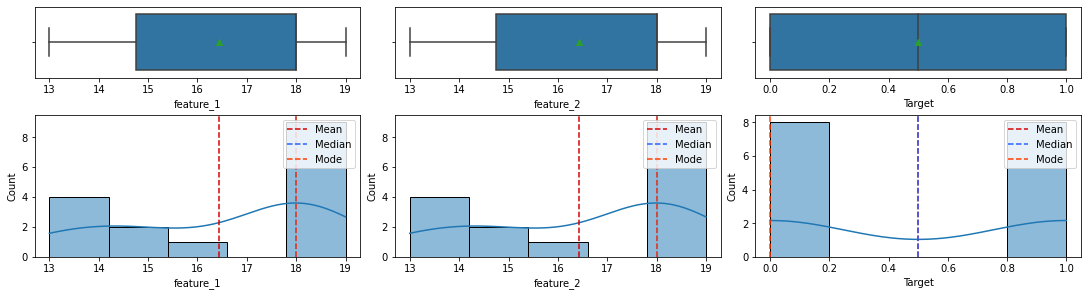

In [10]:
PlotHistBoxGrid(RemoveOutliers(main_data))

In [11]:
RemoveOutliers(main_data)

['feature_1', 'feature_2']


,feature_1,feature_2,Target
0,18,18,1
1,18,18,0
2,18,18,1
3,13,13,0
4,13,13,1
5,14,14,0
6,14,14,1
7,15,15,0
8,15,15,1
9,16,16,0


In [12]:
RemoveOutliers(main_data).corr()

['feature_1', 'feature_2']


,feature_1,feature_2,Target
feature_1,1.000000,1.000000,0.030787
feature_2,1.000000,1.000000,0.030787
Target,0.030787,0.030787,1.000000


In [14]:
TARGET_COLUMN = 'Target'
df1 = main_data.corr()[[TARGET_COLUMN]].copy()
df1["Tranformation"] = "Before"

df2 = RemoveOutliers(main_data).corr()[[TARGET_COLUMN]].copy()
df2["Tranformation"] = "After"

df = pd.concat([df1, df2], axis=0).reset_index()
df

['feature_1', 'feature_2']


,index,Target,Tranformation
0,feature_1,-0.184538,Before
1,feature_2,-0.232018,Before
2,Target,1.000000,Before
3,feature_1,0.030787,After
4,feature_2,0.030787,After
5,Target,1.000000,After


In [ ]:
RemoveOutliers(main_data).info()